In [14]:
#libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [2]:
file = pd.read_csv('Campaign Type.csv', sep='|')

print('columns: {}'.format(file.columns))
print('-'*30)
print('shape: {}'.format(file.shape))
print('-'*30)
file.head(3)

columns: Index(['Campaign Date', 'A/B Test Flag', 'MailingName', 'Scheduled Date',
       'Scheduled Time', 'Sent Date', 'Sent Time', 'Campaign', 'Product Type',
       'Contact Source', 'Winner SL', 'Subject Line', 'Sent', 'Received',
       'Received %', 'Gross Open', 'Unique Open', 'Open Rate', 'Gross Click',
       'Unique Click', 'Click Rate', 'Soft Bounce', 'Soft Bounce %',
       'Hard Bounce', 'Hard Bounce %', 'Unsubscribed', 'Unsubscribed %',
       'Campaign Month', 'Report As on'],
      dtype='object')
------------------------------
shape: (4900, 29)
------------------------------


,Campaign Date,A/B Test Flag,MailingName,Scheduled Date,Scheduled Time,Sent Date,Sent Time,Campaign,Product Type,Contact Source,...,Unique Click,Click Rate,Soft Bounce,Soft Bounce %,Hard Bounce,Hard Bounce %,Unsubscribed,Unsubscribed %,Campaign Month,Report As on
0,2/3/2017,1.0,DebitCardUpgradeDemonitisation_DC_SA_DemonetXs...,2/3/2017,07:46:48 PM,2/3/2017,07:47:13 PM,D.C Upgrade,D.C Upgrade,DebitCardUpgradeDemonitisation_DC_SA_DemonetXs...,...,1,0.16%,0,0.00%,0,0.00%,0,0.00%,Feb'17,1/30/2018
1,2/3/2017,1.0,DebitCardUpgradeDemonitisation_DC_SA_DemonetXs...,2/3/2017,07:39:46 PM,2/3/2017,07:40:17 PM,D.C Upgrade,D.C Upgrade,DebitCardUpgradeDemonitisation_DC_SA_DemonetXs...,...,0,0.00%,0,0.00%,0,0.00%,0,0.00%,Feb'17,1/30/2018
2,2/3/2017,1.0,DebitCardUpgradeDemonitisation_DC_SA_DemonetXs...,2/3/2017,07:54:21 PM,2/3/2017,07:54:36 PM,D.C Upgrade,D.C Upgrade,DebitCardUpgradeDemonitisation_DC_SA_DemonetXs...,...,1,0.26%,0,0.00%,0,0.00%,0,0.00%,Feb'17,1/30/2018


In [3]:
#for now picking only a subset of file

file = file.loc[:,['Campaign','Product Type','Subject Line','Sent','Unique Open','Unique Click']]
print('shape: ', file.shape)
print('-'*30)
file.head()

shape:  (4900, 6)
------------------------------


,Campaign,Product Type,Subject Line,Sent,Unique Open,Unique Click
0,D.C Upgrade,D.C Upgrade,"Dear %%Opportunity_Name%%, avail benefits wort...",611,71,1
1,D.C Upgrade,D.C Upgrade,"Dear %%Opportunity_Name%%, avail benefits wort...",743,77,0
2,D.C Upgrade,D.C Upgrade,"Dear %%Opportunity_Name%%, benefits worth Rs.1...",385,41,1
3,D.C Upgrade,D.C Upgrade,"Dear %%Opportunity_Name%%, avail benefits wort...",1084,102,1
4,D.C Upgrade,D.C Upgrade,Enjoy Premium benefits on our Signature Debit ...,607,44,1


In [4]:
# renaming columns
file.columns = ['campaign', 'prod_type', 'subject', 'sent', 'uniq_open', 'uniq_click']

In [5]:
file['openrate%'] = 100*(file['uniq_open'] / file['sent'])
file['clickrate%'] = 100*(file['uniq_click'] / file['sent'])

In [6]:
# cleaning subject lines - keep alphabets, tokenizing
file['subject'] = file['subject'].str.lower()
file['subject'] = file['subject'].apply(''.join).str.replace('[^A-Za-z\s]+', '').str.split(expand=False)

In [8]:
# cleaning subjet lines - remove stop words
stop_words = set(stopwords.words('english'))

file['subject'] = file['subject'].apply(lambda x: [w for w in x if  not w in stop_words])
file['subject'] = file['subject'].apply(lambda x : ','.join(x))

In [9]:
#file.head()

,campaign,prod_type,subject,sent,uniq_open,uniq_click,openrate%,clickrate%
0,D.C Upgrade,D.C Upgrade,"dear,opportunityname,avail,benefits,worth,rs,p...",611,71,1,11.620295,0.163666
1,D.C Upgrade,D.C Upgrade,"dear,opportunityname,avail,benefits,worth,rs,p...",743,77,0,10.363392,0.000000
2,D.C Upgrade,D.C Upgrade,"dear,opportunityname,benefits,worth,rs,await,d...",385,41,1,10.649351,0.259740
3,D.C Upgrade,D.C Upgrade,"dear,opportunityname,avail,benefits,worth,rs,p...",1084,102,1,9.409594,0.092251
4,D.C Upgrade,D.C Upgrade,"enjoy,premium,benefits,signature,debit,card,up...",607,44,1,7.248764,0.164745


In [ ]:
# check for a word - 'pizza'

# file.loc[ file['subject'].astype(str).str.contains('pizza', case=False)]

In [99]:
def avg_rate(x,y):
    if y==0:
        return 0 # handle div by zero
    return (x / y )*100

def word_popularity(word):
    """
    input arg type: string
    returns: open rate, click rate for the word
    """
    df = pd.DataFrame() # flush earlier entries
    df = file.loc[ file['subject'].astype(str).str.contains(word, case=False)]
    total_sent = df['sent'].sum()
    total_open = df['uniq_open'].sum()
    total_click = df['uniq_click'].sum()
    
    word_openrate = avg_rate(total_open, total_sent) #(total_open / total_sent)*100
    word_clickrate = avg_rate(total_click, total_sent) #(total_click / total_sent)*100
    return word_openrate, word_clickrate

In [102]:
def overall_popularity(uniq_word_series):
    """
    input arg type: pandas series (for e.g. df['subjects'])
    returns: dataframe
    """
    popularity_df = pd.DataFrame(columns = ['word','openrate%','clickrate%','campaign','prod_type'])
    uniq_words_list = list(uniq_word_series.astype(str).str.split(',', expand=True).stack().unique()) # all uniq words in df
    
    row_index = 0
    for each in uniq_words_list:
        popularity_df.loc[row_index, ['word']] = each
        popularity_df.loc[row_index, ['openrate%']], popularity_df.loc[row_index, ['clickrate%']] = word_popularity(each)
        popularity_df.loc[row_index, ['campaign']] = ','.join(list(file.loc[file['subject'].astype(str).str.contains(each, case=False),['campaign']].stack().unique()))
        popularity_df.loc[row_index, ['prod_type']] = ','.join(list(file.loc[file['subject'].astype(str).str.contains(each, case=False),['prod_type']].stack().unique()))
        row_index += 1
    return popularity_df      

In [103]:
famous_words = overall_popularity(file['subject'])
famous_words.head()

,word,openrate%,clickrate%,campaign,prod_type
0,dear,8.92105,0.12901,"D.C Upgrade,D.C Acquisition,DCVoucherActivatio...","D.C Upgrade,DC,D.C,DCVoucherActivation,DCTrans..."
1,opportunityname,8.92105,0.12901,"D.C Upgrade,D.C Acquisition,DCVoucherActivatio...","D.C Upgrade,DC,D.C,DCVoucherActivation,DCTrans..."
2,avail,8.59171,0.186421,"D.C Upgrade,NB Registration,D.C Acquisition,MB...","D.C Upgrade,NB Registration,DC,MB,D.C,MB Trans..."
3,benefits,7.75474,0.0855263,"D.C Upgrade,D.C Acquisition,DCVoucherActivation","D.C Upgrade,DC,D.C,DCVoucherActivation"
4,worth,7.79559,0.101891,"D.C Upgrade,MB Transaction,NB Registration,D.C...","D.C Upgrade,NB Registration,DC,MB Transaction,..."


In [118]:
# creating word cloud with open-rate and with click-rate
def plot_top_words(popularity_df, prod_type = ''):
    """
    input arg: output dataframe of overall_popularity & product type (optional)
    returns: word cloud plots of avg openrate and avg clickrate - overall(if prod_type is None) & product-wise(if prod_type)
    """
    # if any product type specified
    if prod_type:
        popularity_df = popularity_df.loc[popularity_df['prod_type'].astype(str).str.contains(prod_type, case=False), :]
        
    open_dict, click_dict = {}, {}
    for i, each in popularity_df.iterrows():
        if each['openrate%'] != 0.0:
            open_dict[each['word']] = each['openrate%']
        if each['clickrate%'] != 0.0:
            click_dict[each['word']] = each['clickrate%']

    wordcloud1 = WordCloud(font_path='/home/aman/Desktop/SARAL_Campaign/fonts/CabinSketch-Bold.otf',
                          width=1800,
                          height=1400,
                          background_color='white').generate_from_frequencies(frequencies = open_dict)
    plt.figure(figsize=(12, 8))
    plt.title('Top Words that engage more Open Rate')
    plt.imshow(wordcloud1, interpolation = "bilinear")
    plt.axis("off")
    plt.savefig('./openrate_wordcloud.png', dpi=300)
    plt.show()

    wordcloud2 = WordCloud(font_path='/home/aman/Desktop/SARAL_Campaign/fonts/CabinSketch-Bold.otf',
                          width=1800,
                          height=1400,
                          background_color='white').generate_from_frequencies(frequencies = click_dict)
    plt.figure(figsize=(12, 8))
    plt.title('Top Words that engage more Click Rate')
    plt.imshow(wordcloud2, interpolation = "bilinear")
    plt.axis("off")
    plt.savefig('./clickrate_wordcloud.png', dpi=300)
    plt.show()
    

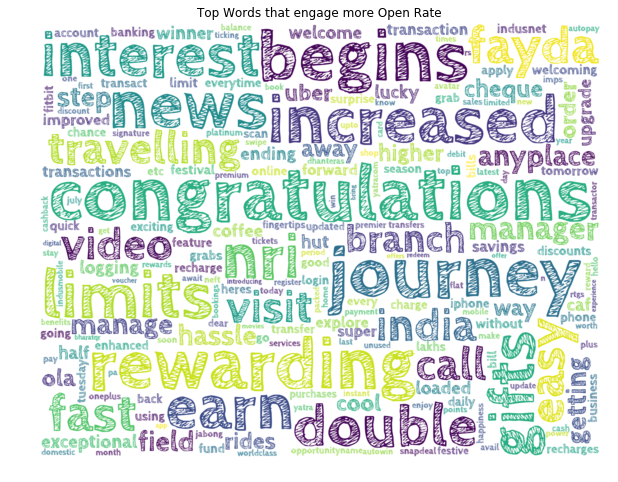

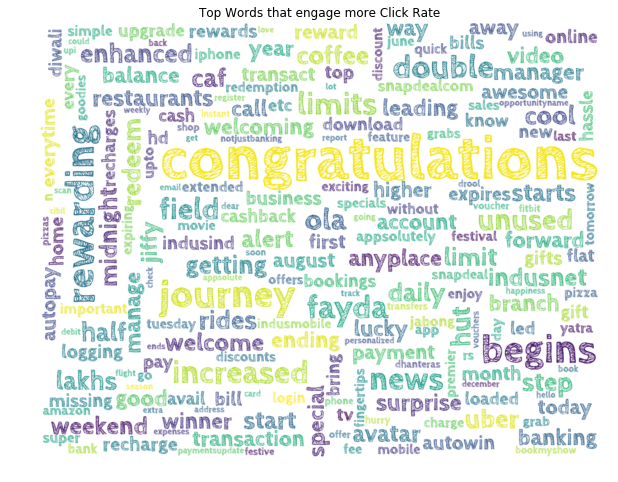

In [119]:
plot_top_words(famous_words)

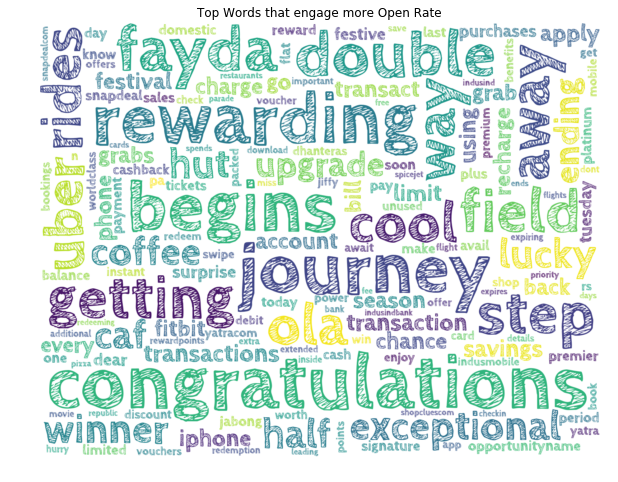

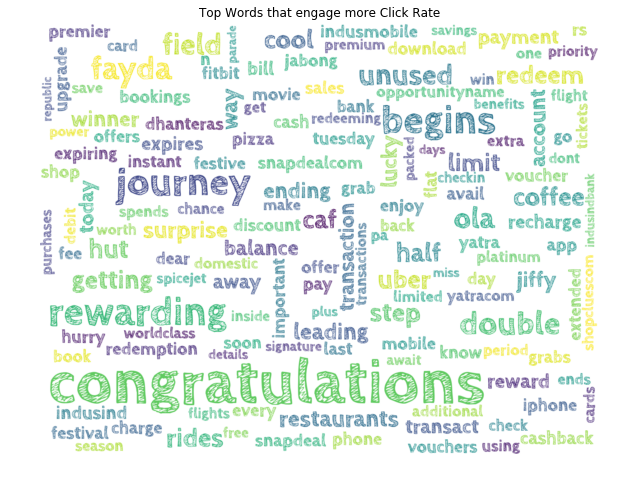

In [120]:
plot_top_words(famous_words, 'DC')